In [98]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import timedelta
import altair as alt
import glob
import os

# CAS Data Science Projekt Sleep Analysis - Data Wrangling

## Datenquellen

**Mond Phasen**
Abruf: 03.04.2022
Quelle: `https://www.timeanddate.de/mond/phasen/` (Location: Basel). Händischer Download in ein CSV ohne Spalte Lunation und Duration
Dateien: `raw/moon/*`

**Schlafdaten**
Abruf: XX.XX.XXXX
Quelle: Daten Export von Fitbit Schlafdaten von privatem Account, CSV Export
Dateien: `raw/sleep/tbd`

## 1. Mond-Phasen

### 1.1 Datenaufbereitung

Ich habe diese zwei kleinen Tabellen (2021, 2022) von Hand in ein Excel bzw. CSV kopiert, da der Aufwand einen Crawler zu schreiben für diese paar Zeilen dafür zu gross gewesen wäre. Nun muss ich die Daten in ein geeignetes Format bringen. Grundsätzlich möchte ich pro Datum wissen, welche Mondphase das ist.

In [99]:
# read data
moon2021_raw = pd.read_csv('raw/moon/moon-phases-2021.csv')
moon2022_raw = pd.read_csv('raw/moon/moon-phases-2022.csv')

# have a look
print(moon2021_raw.head())
print(moon2022_raw.head())

# drop unnecessary column
moon2021_raw.drop('Unnamed: 4', inplace=True, axis=1)
moon2022_raw.drop('Unnamed: 4', inplace=True, axis=1)

# have a look again
print(moon2021_raw.head())
print(moon2022_raw.head())

     New Moon First Quarter   Full Moon Third Quarter  Unnamed: 4
0  2021-01-13    2021-01-20  2021-01-28    2021-01-06         NaN
1  2021-02-11    2021-02-19  2021-02-27    2021-02-04         NaN
2  2021-03-13    2021-03-21  2021-03-28    2021-03-06         NaN
3  2021-04-12    2021-04-20  2021-04-27    2021-04-04         NaN
4  2021-05-11    2021-05-19  2021-05-26    2021-05-03         NaN
     New Moon First Quarter   Full Moon Third Quarter  Unnamed: 4
0  2022-01-02    2022-01-09  2022-01-18    2022-01-25         NaN
1  2022-02-01    2022-02-08  2022-02-16    2022-02-23         NaN
2  2022-03-02    2022-03-10  2022-03-18    2022-03-25         NaN
3  2022-04-01    2022-04-09  2022-04-16    2022-04-23         NaN
4  2022-04-30    2022-05-09  2022-05-16    2022-05-22         NaN
     New Moon First Quarter   Full Moon Third Quarter
0  2021-01-13    2021-01-20  2021-01-28    2021-01-06
1  2021-02-11    2021-02-19  2021-02-27    2021-02-04
2  2021-03-13    2021-03-21  2021-03-28    202

In [100]:

def convert_all_dates(df, format):
    """Converts all the date strings into proper datetime objects."""

    new_moon = 'New Moon'
    df[new_moon] = pd.to_datetime(df[new_moon], format=format)
    first_quarter = 'First Quarter'
    df[first_quarter] = pd.to_datetime(df[first_quarter], format=format)
    full_moon = 'Full Moon'
    df[full_moon] = pd.to_datetime(df[full_moon], format=format)
    third_quarter = 'Third Quarter'
    df[third_quarter] = pd.to_datetime(df[third_quarter], format=format)

    return df

In [101]:
format = '%Y-%m-%d'
moon2021_raw = convert_all_dates(moon2021_raw, format)
moon2022_raw = convert_all_dates(moon2022_raw, format)

print(moon2021_raw.dtypes)
print(moon2022_raw.dtypes)

New Moon         datetime64[ns]
First Quarter    datetime64[ns]
Full Moon        datetime64[ns]
Third Quarter    datetime64[ns]
dtype: object
New Moon         datetime64[ns]
First Quarter    datetime64[ns]
Full Moon        datetime64[ns]
Third Quarter    datetime64[ns]
dtype: object


In [102]:
def flatten_moon_phases(df):
    """Flattens the moon phases to dates e.g. 2020-01-01 New Moon"""
    flattened = pd.DataFrame(columns={'Date', 'Moon Phase'})
    for index, row in df.iterrows():

        first_quarter = {'Date': row['First Quarter'], 'Moon Phase': 'First Quarter'}
        flattened = flattened.append(first_quarter, ignore_index = True)

        new_moon = {'Date': row['New Moon'], 'Moon Phase': 'New Moon'}
        flattened = flattened.append(new_moon, ignore_index = True)

        third_quarter = {'Date': row['Third Quarter'], 'Moon Phase': 'Third Quarter'}
        flattened = flattened.append(third_quarter, ignore_index = True)

        full_moon = {'Date': row['Full Moon'], 'Moon Phase': 'Full Moon'}
        flattened = flattened.append(full_moon, ignore_index = True)


    return flattened

In [103]:
moon_2021 = flatten_moon_phases(moon2021_raw)
moon_2022 = flatten_moon_phases(moon2022_raw)

/var/folders/05/dt2l3w6x5vj4rljb35fc6sgr0000gn/T/ipykernel_69223/3004303789.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  flattened = flattened.append(first_quarter, ignore_index = True)
/var/folders/05/dt2l3w6x5vj4rljb35fc6sgr0000gn/T/ipykernel_69223/3004303789.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  flattened = flattened.append(new_moon, ignore_index = True)
/var/folders/05/dt2l3w6x5vj4rljb35fc6sgr0000gn/T/ipykernel_69223/3004303789.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  flattened = flattened.append(third_quarter, ignore_index = True)
/var/folders/05/dt2l3w6x5vj4rljb35fc6sgr0000gn/T/ipykernel_69223/3004303789.py:16: FutureWarning: The frame.append method is deprecated and will be removed f

In [104]:
# drop ones containing no date
moon_2021.dropna(axis=0, inplace=True)
moon_2022.dropna(axis=0, inplace=True)

### 1.2 Fertige Datensätze

In [105]:
print("File Mond Phasen 2021 Dimensionen: "+ str(moon_2021.shape))
moon_2021.tail(10)

File Mond Phasen 2021 Dimensionen: (49, 2)


,Moon Phase,Date
39,Full Moon,2021-10-20 00:00:00
40,First Quarter,2021-11-11 00:00:00
41,New Moon,2021-11-04 00:00:00
42,Third Quarter,2021-10-28 00:00:00
43,Full Moon,2021-11-19 00:00:00
44,First Quarter,2021-12-11 00:00:00
45,New Moon,2021-12-04 00:00:00
46,Third Quarter,2021-11-27 00:00:00
47,Full Moon,2021-12-19 00:00:00
50,Third Quarter,2021-12-27 00:00:00


In [106]:
print("File Mond Phasen 2022 Dimensionen: "+ str(moon_2022.shape))
moon_2022.tail(10)

File Mond Phasen 2022 Dimensionen: (50, 2)


,Moon Phase,Date
40,First Quarter,2022-11-01 00:00:00
41,New Moon,2022-10-25 00:00:00
42,Third Quarter,2022-11-16 00:00:00
43,Full Moon,2022-11-08 00:00:00
44,First Quarter,2022-11-30 00:00:00
45,New Moon,2022-11-23 00:00:00
46,Third Quarter,2022-12-16 00:00:00
47,Full Moon,2022-12-08 00:00:00
48,First Quarter,2022-12-30 00:00:00
49,New Moon,2022-12-23 00:00:00


In [107]:
# combined
combined_moon = moon_2021.merge(moon_2022, how='outer',on=['Date','Moon Phase'])
combined_moon.to_csv('prepared/moon.csv')

### 1.3 Erste Visualisierungen

<AxesSubplot:xlabel='Moon Phase', ylabel='count'>

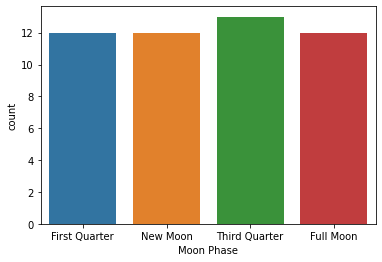

In [108]:
sns.countplot(data=moon_2021, x='Moon Phase')

<AxesSubplot:xlabel='Moon Phase', ylabel='count'>

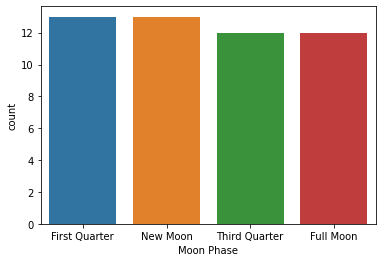

In [109]:
sns.countplot(data=moon_2022, x='Moon Phase')

In [110]:
from altair.utils.data import to_values

alt.Chart.from_dict({
    "data": to_values(moon_2021),
    "mark": "circle",
    "encoding": {
        "x": {
            "field": "Date",
            "type": "temporal",
        },
        "color": {
            "field": "Moon Phase",
            "type": "nominal"
        },
         "y": {
            "field": "Moon Phase",
            "type": "nominal",
        }
    }
})

alt.Chart(...)

In [111]:
alt.Chart.from_dict({
    "data": to_values(combined_moon),
    "mark": "circle",
    "encoding": {
        "x": {
            "field": "Date",
            "type": "temporal",
        },
        "color": {
            "field": "Moon Phase",
            "type": "nominal"
        },
         "y": {
            "field": "Moon Phase",
            "type": "nominal",
        }
    }
})

alt.Chart(...)

## 2. Fitbit - Average Heart Rate

### 2.1 Datenaufbereitung

In [112]:
def get_bpm(row):
    entry = row['value']
    return entry['bpm']

def get_confidence(row):
    entry = row['value']
    return entry['confidence']


In [113]:

# does not respect confidence yet
def process_heart_df(dataframe):
    dataframe['date'] = pd.to_datetime(dataframe['dateTime']).dt.date
    dataframe.drop(columns=['dateTime'], inplace=True)
    dataframe['bpm'] = dataframe.apply(get_bpm, axis=1)
  # dataframe['confidence'] = df.apply(get_confidence, axis=1)
    dataframe.drop(columns=['value'], inplace=True)
    dataframe = dataframe.groupby('date', sort=False)['bpm'].mean().reset_index()
    return dataframe

In [114]:
# care, this takes a while - grab a coffee

heart_path = os.path.abspath("raw/heart")
heart_filenames = glob.glob(heart_path + "/*.json")
dfs = []

for filename in heart_filenames:
    read = pd.read_json(filename)
    df = process_heart_df(read)
    dfs.append(df)

heart = pd.concat(dfs)
heart.reset_index(drop=True, inplace=True)

In [115]:
heart.head()

,date,bpm
0,2022-03-09,59.587444
1,2022-03-10,68.815310
2,2022-04-01,67.736052
3,2022-04-02,68.428666
4,2021-12-08,82.640894


### 2.2 Fertiger Datensatz

In [116]:
heart.to_csv('prepared/heart.csv')
print("File Heart Rate Dimensionen: "+ str(heart.shape))
heart.tail(10)

File Heart Rate Dimensionen: (225, 2)


,date,bpm
215,2021-12-26,63.254697
216,2021-12-27,68.484158
217,2022-02-03,66.031873
218,2022-02-04,72.069394
219,2022-01-01,55.680693
220,2022-01-02,71.343988
221,2021-12-30,54.444444
222,2021-12-31,69.894339
223,2022-02-11,67.909278
224,2022-02-12,68.187272


### 2.3 Erste Visualisierungen

<AxesSubplot:ylabel='Count'>

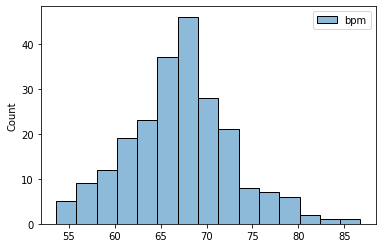

In [117]:
sns.histplot(data=heart)

Die häufigsten Vorkommnisse sind zwischen 60-70 bpm. Das scheint okay zu sein.
Die Ober- (ca. 90) und Untergrenzen (ca. 50) scheinen auch gut möglich.

## 3. Fitbit - Temperatur Abweichungen

### 3.1 Datenaufbereitung

In [118]:

def process_temp_df(dataframe):
    dataframe.drop(columns=['sensor_type'], inplace=True)
    dataframe['date'] = pd.to_datetime(dataframe['recorded_time']).dt.date
    dataframe.drop(columns=['recorded_time'], inplace=True)
    dataframe = dataframe.groupby('date', sort=False)['temperature'].mean().reset_index()
    return dataframe

In [119]:
# care, this takes a while - grab a coffee

temp_path = os.path.abspath("raw/temp")
temp_filenames = glob.glob(temp_path + "/*.csv")
temp_dfs = []

for filename in temp_filenames:
    read = pd.read_csv(filename)
    processed = process_temp_df(read)
    temp_dfs.append(processed)

temp = pd.concat(temp_dfs)
temp.reset_index(drop=True, inplace=True)

In [120]:
temp.head()

,date,temperature
0,2022-03-04,-2.494845
1,2022-03-10,-3.100641
2,2022-01-01,-2.14144
3,2022-01-15,-0.019856
4,2022-01-14,-1.975761


### 3.2 Fertiger Datensatz

In [121]:
temp.to_csv('prepared/temp.csv')
print("File Temperature Deviations Dimensions: "+ str(temp.shape))
temp.tail(10)

File Temperature Deviations Dimensions: (103, 2)


,date,temperature
93,2022-04-03,-2.311031
94,2022-03-20,-2.288679
95,2022-01-19,-1.669774
96,2022-01-25,-2.424891
97,2022-01-31,-2.063657
98,2022-01-30,-2.324723
99,2022-01-24,-1.72363
100,2022-01-18,-2.356942
101,2022-03-21,-3.247348
102,2022-03-09,-1.638228


### 3.3 Erste Visualisierungen

<AxesSubplot:ylabel='Count'>

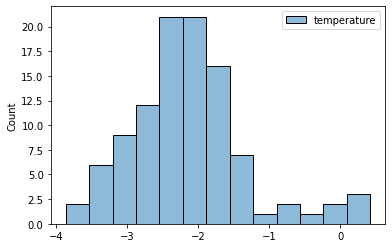

In [122]:
sns.histplot(data=temp)

## 4. Fitbit - Sleep Score

### 4.1 Datenaufbereitung

In [123]:
sleep = pd.read_csv('raw/sleep/sleep_score.csv')
sleep.sample(frac=1)
sleep.drop(columns=['sleep_log_entry_id'], inplace=True)

sleep['date'] = pd.to_datetime(sleep['timestamp']).dt.date
sleep.drop(columns=['timestamp'], inplace=True)


In [124]:
sleep.head()

,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,date
0,82,21,22,39,68,61,0.076490,2022-04-08
1,72,18,13,41,80,59,0.087133,2022-04-07
2,71,17,14,40,66,58,0.084915,2022-04-06
3,78,21,14,43,67,56,0.061356,2022-04-05
4,77,22,20,35,105,57,0.081747,2022-04-04


In [125]:
sleep.shape

(108, 8)

### 4.2 Fertiger Datensatz

In [126]:
sleep.to_csv('prepared/sleep.csv')
print("Sleep File Dimensionen: "+ str(sleep.shape))

Sleep File Dimensionen: (108, 8)


### 4.3 Erste Visualisierungen

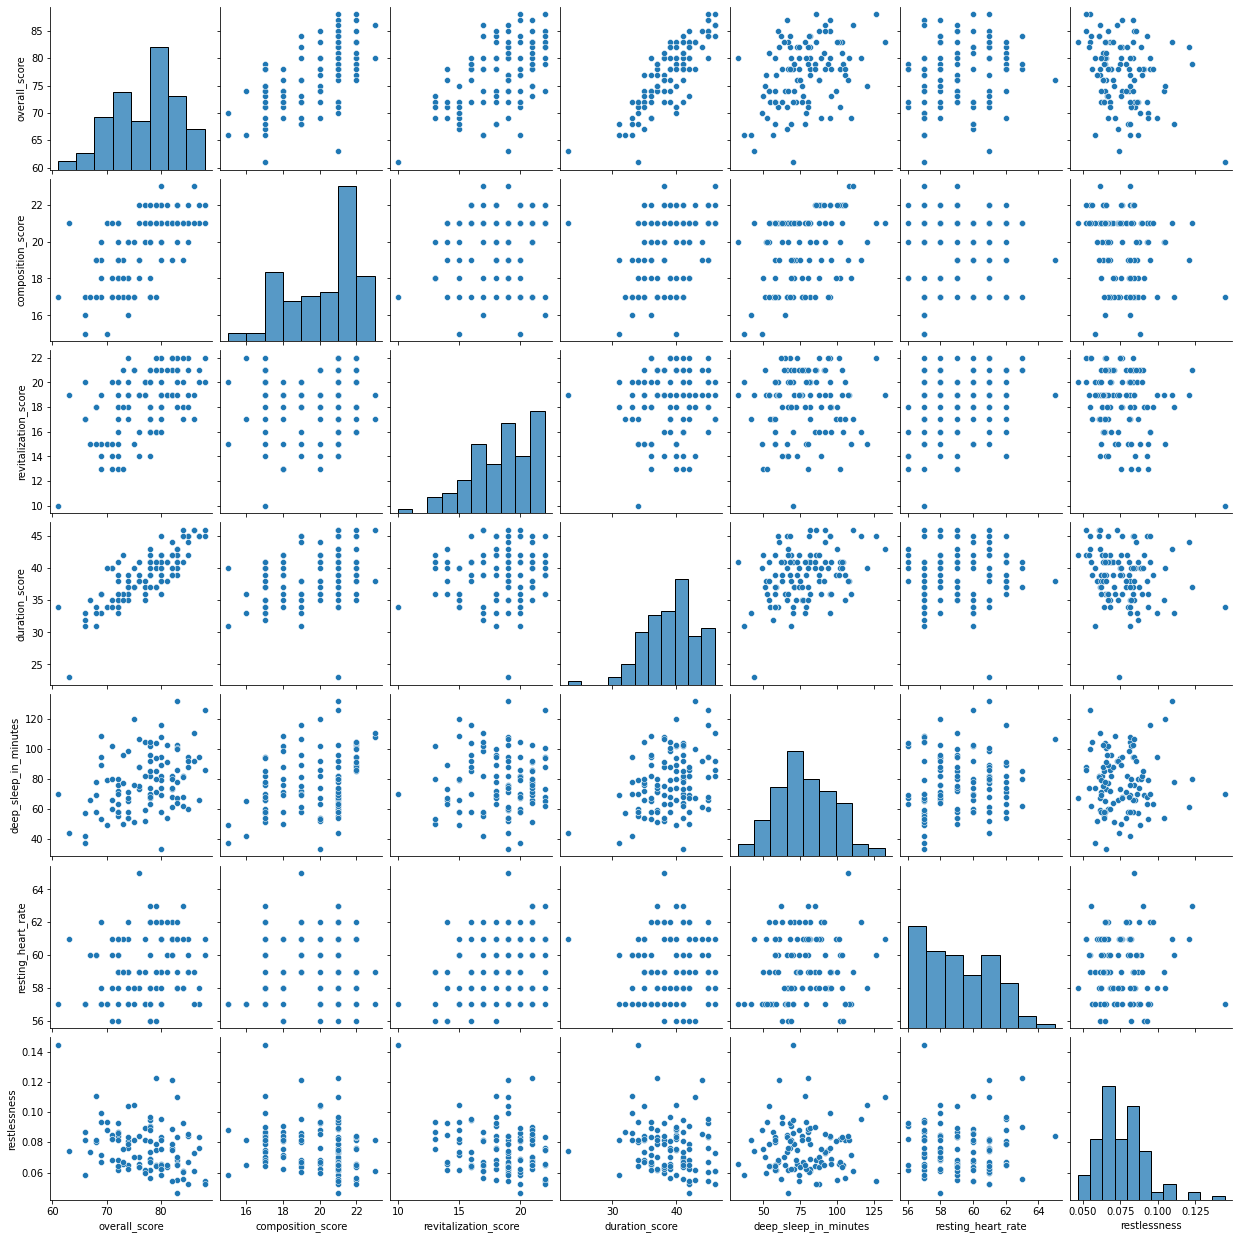

In [127]:
sns.pairplot(sleep)

In [129]:
corr = sleep.corr()
corr.style.background_gradient(cmap='coolwarm')

,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
overall_score,1.000000,0.631711,0.524367,0.828636,0.380370,0.189454,-0.313663
composition_score,0.631711,1.000000,0.124504,0.368887,0.360848,0.084740,-0.233844
revitalization_score,0.524367,0.124504,1.000000,0.064706,0.045112,0.313109,-0.230053
duration_score,0.828636,0.368887,0.064706,1.000000,0.357183,0.035477,-0.200366
deep_sleep_in_minutes,0.380370,0.360848,0.045112,0.357183,1.000000,0.089530,0.022834
resting_heart_rate,0.189454,0.084740,0.313109,0.035477,0.089530,1.000000,0.000902
restlessness,-0.313663,-0.233844,-0.230053,-0.200366,0.022834,0.000902,1.000000
